# Part 3 : Modelling Spread of Rumours through Echo Chambers

## Phenomena to be modelled & simulated

Why are we seeing a sudden rise in the spread of fake news? How did facebook play a role in influencing the 2016 presedential selections? Are opinions taking precedence over facts in todays online world?

With some of these questions in mind, this section is attempting to model and simulate the effect that echo chambers have on the spread of rumours and fake news in online social networks. Echo chambers effect occurs when people are exposed situations that conform their opinions and interact with people that have similar interests and agree with their opnions. 

There are certain signs that point to a link between these two phenomena—echo chambers and the spread of misinformation—since homogeneous clusters of users with a preference for self-confirmation seem to provide capable green-houses for the seedling of rumors and misinformation [7]. A polarized digital space where users tend to promote their favorite narratives, form polarized groups and resist information that does not conform to their beliefs may be the fertilizer that makes the Internet so fertile for the growth of misinformation. Therefore, echo chambers reinforce existing perspectives and foster confirmations biases[5]. In the following section, we attempt to build network simulation models to study the effect of such opinion and network polarised clusters on the virality of a misinformation. 

## Conceptual Model

In the network modelling of this phenomena, we simulate a network where the nodes are the people belonging to the network and the edges between the nodes indicate the other people in the network to whom they are connected with. 

We then simulate an echo chamber within this network, which is a cluster of closely connected nodes such that its intra-cluster connectivity is maximised and inter-cluster connectivity is minimised. The users in the echo-chamber are characterised by 2 properties: opinion and network polarisation. 

Opinion polarization means that they, in relation to a given question, are more inclined to share similar views. 

Network polarization means that they are more densely connected with each other than with the outside network. In other words, an echo chamber is a tightly connected set of nodes more inclined to share a common view on a given narrative. For the sake of simplicity, this model focuses on the existence of a single echo-chamber in a larger network.

The second aspect of the echo chambers, opinion polarization, implies that their thresholds are lower than that of the surrounding network. This henomena is desribe in network terms as homophily: the probability that neighboring nodes have similar thresholds for activation. 

In [948]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import numpy as np
from networkx.algorithms import community
import random

**Exercise 1 :** Write a helper funtion to draw a network using networkx and color the nodes to which the information has spread in blue and the remaining nodes in green

In [873]:
def draw_activated_nodes(G):
    color_map = []
    for node in G:
        if G.nodes[node]['status'] == 'activated':
            color_map.append('blue')
        else: color_map.append('green')      
    nx.draw(G,node_color = color_map,with_labels = True)
    plt.show()
    

**Exercise 2 :** Replicate the 'draw_activate_nodes' function, but instead the blue nodes should represent the nodes that belong to the echo chamber

In [964]:
def draw_echo_chamber(G, echo_chamber):
    color_map = []
    for node in G:
        if node in echo_chamber:
            color_map.append('blue')
        else: color_map.append('green')      
    nx.draw(G,node_color = color_map,with_labels = True)
    plt.show()

**Exercise 3 :** Given a network of nodes and edges, construct an 'echo-chamber' within the network. The parameters and their role in the echo chamber is defined below.

Run the function on random Erdős-Rényi network and visualise the nodes

Each node in the network is assigned a threshold value. The threshold value indicates the minimum percentage of neighbors who need to believe in an information, for the node/ person to believe in that information.

Variable definitions are:

N = Number of nodes in the network

E = Number of edges in the network

c = Fraction of nodes that belong to the echo chamber (0.2)

k = average degree of the nodes

θ = Threshold of nodes outside the echo chamber

θ − P<sub>0</sub> = Threshold of nodes inside the echo chamber


1. Select cN nodes from the network
2. Select P<sub>n</sub> kE edges from this set such that exactly one of the connected nodes belong to the cluster. These are removed, and replaced by edges where both nodes belong to the cluster. 
3. Nodes outside the cluster are set to have activation threshold θ, and nodes in the cluster are set to have threshold θ − P<sub>0</sub>.

In [1128]:
def create_echo_chamber(G, nw_polarisation, opinion_polarisation, viz =0):    
    echo_chamber_size = int(0.20*G.number_of_nodes())
    echo_chamber = random.sample(G.nodes(), echo_chamber_size)
    #communities_generator = community.girvan_newman(G)
    #top_level_communities = next(communities_generator)
    #echo_chamber = sorted(map(sorted, top_level_communities))[0]
    N = G.number_of_nodes()
    E = G.number_of_edges()
    avg_degree = E / float(N)

    if(viz==1):
        print("Random nodes selected for the echo chamber")
        draw_echo_chamber(G, echo_chamber)
    modified_edge_count = 0 
    #print(E)
    #print(avg_degree)
    #print(nw_polarisation * echo_chamber_size * avg_degree )
    external_edge_cnt = 0
    for node in echo_chamber:
        nghbrs = list(G.neighbors(node))
        for neighbor in nghbrs:
            if(neighbor not in echo_chamber):
                external_edge_cnt = external_edge_cnt + 1
    for node in echo_chamber:
        G.nodes[node]['threshold'] =  G.nodes[node]['threshold'] - opinion_polarisation
        nghbrs = list(G.neighbors(node))
        for neighbor in nghbrs:
            if modified_edge_count >= (nw_polarisation *external_edge_cnt ):
                break;
            if(neighbor not in echo_chamber):
                G.remove_edge(node, neighbor)
                new_neighbor = random.choice(echo_chamber);
                while(G.has_edge(node, new_neighbor) or node==new_neighbor):
                    new_neighbor = random.choice(echo_chamber)
                G.add_edge(node, new_neighbor)
                modified_edge_count = modified_edge_count + 1
    #print(modified_edge_count)
    if(viz == 1):
        print("Echo Chamber post modification of the edges")
        draw_echo_chamber(G, echo_chamber)
    return G, echo_chamber


Random nodes selected for the echo chamber


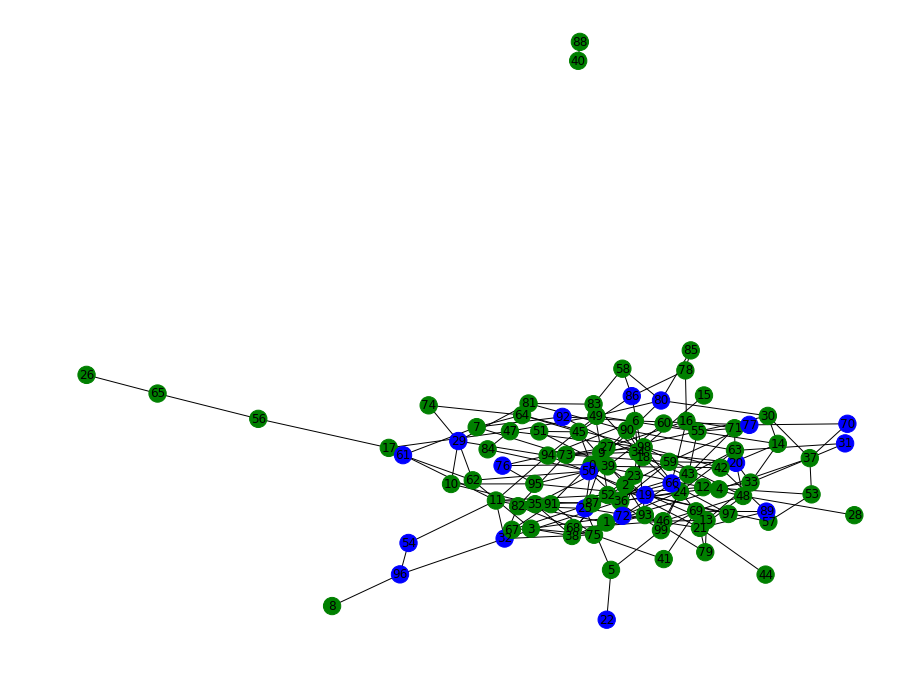

Echo Chamber post modification of the edges


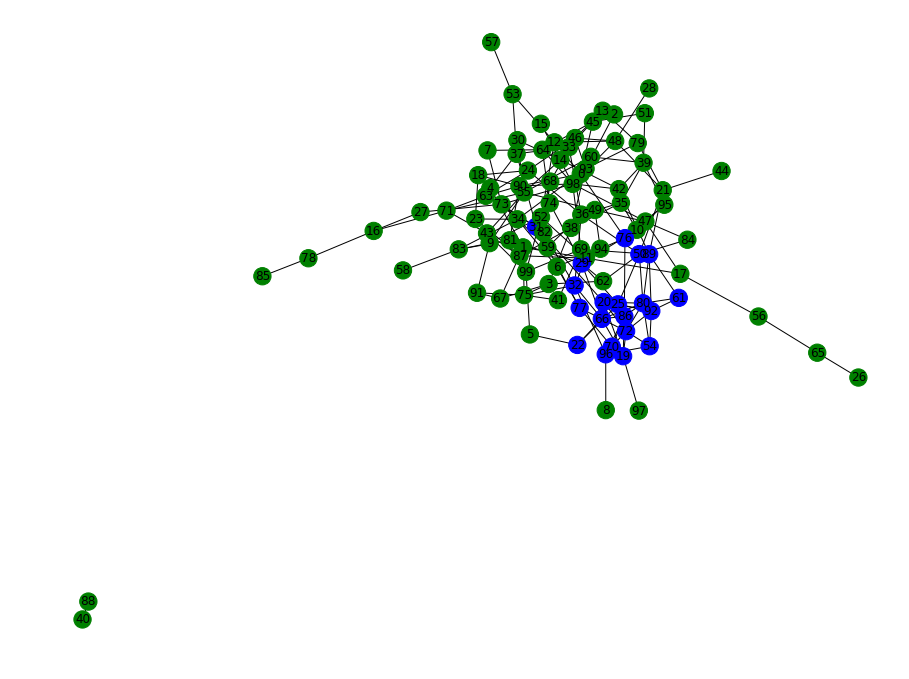

In [1144]:
G = nx.erdos_renyi_graph(100, 0.04)
status = 'healthy'
threshold = 0.27
nx.set_node_attributes(G, status, 'status')
nx.set_node_attributes(G, threshold, 'threshold')

grph, ec = create_echo_chamber(G, 0.6, 0.05, 1)

**Exercise 4:** Write a function to model the spread of information starting from a random node in the echo chamber. The parameter that are taken as input to the function are:
1. Network Polarisation: Factor by which nodes in the echo chamber are more tightly connected within other nodes in the chamber as compared to nodes outside it
2. N = Number of nodes
3. Opinion Polarisation: Factor by which the threshold of nodes in the echo chamber is less than the other nodes
4. Threshold: % of neighbors that believe in the information for a node to believe in it too
5. niter: Number of iterations


In [1106]:

def model_information_diffusion(nw_polarisation, N, opinion_polarisation, threshold, niter, viz = 0):
    res = []
    for i in range(niter):
        G = nx.erdos_renyi_graph(N, 0.04)
        status = 'healthy'
        nx.set_node_attributes(G, status, 'status')
        nx.set_node_attributes(G, threshold, 'threshold')

        G, echo_chamber = create_echo_chamber(G, nw_polarisation, opinion_polarisation)

        activator_node = random.choice(echo_chamber)
        
        G.nodes[activator_node]['status'] = "activated"
        for neighbor in G.neighbors(activator_node):
            G.nodes[neighbor]['status'] = "activated"

        while True:
            prev_status = nx.get_node_attributes(G, 'status')
            for node in list(G.nodes):
                act_count = 0
                if G.nodes[node]['status'] != "activated":
                    status = nx.get_node_attributes(G, 'status')
                    neighbor_count = len(list(G.neighbors(node)))
                    for neighbor in G.neighbors(node):
                        if status[neighbor] == "activated":
                            act_count = act_count + 1
                    if act_count > (neighbor_count *  G.nodes[node]['threshold'] ) and act_count!=0:
                        G.nodes[node]['status'] = "activated"
            curr_status = nx.get_node_attributes(G, 'status')
            matches = len([i for i, j in zip(prev_status.values(), curr_status.values()) if i == j]) 
            if matches == G.number_of_nodes():
                break
        if(viz == 1):
            print("Final Spread of Information")
            draw_activated_nodes()

        status = nx.get_node_attributes(G, 'status')
        res.append(round(sum( x == 'activated' for x in status.values() )/ N, 4))
    return res


In [1152]:
model_information_diffusion(nw_polarisation= 0.6, N=100, opinion_polarisation=0.1, threshold0.27, 1, viz = 100))

SyntaxError: invalid syntax (<ipython-input-1152-f9a583b3c4bd>, line 1)

**Exercise 5:** Study the relationship between Virality and Network Polarisation (P <sub>n</sub>) and Virality (V) over 100 iterations of the model with random graphs. 


Discuss the results of the simulation and how does it relate to the overall phenomena

For a set of runs, **Virality** is defined as fraction of times in these runs that a majority of the nodes are activated. If greater that 50% of the nodes in the network have received the information and believe in it, then the information is considered to have cascaded globally [8] and is measure as viral.


In [1150]:
N_list = range(100, 400, 75) 
nw_polarisation_list = np.linspace(0,1,7) 
threshold_list = np.linspace(0.15,0.4,7)
opinion_polarisation_list = np.linspace(0.0,0.27,5) #range(0.0, 0.27, 0.03) #[0.0, 0.06, 0.12, 0.18, 0.24]
niter = 100

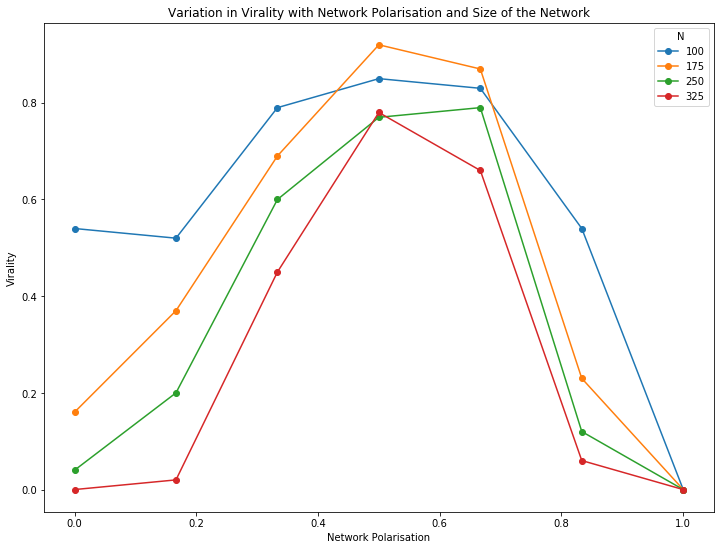

In [1151]:
opinion_polarisation = 0
threshold = 0.27
for N in N_list:
    virality = []
    for nwp in nw_polarisation_list:
        result = model_information_diffusion(nwp, N, opinion_polarisation, threshold, niter)
        spread = sum(i >= 0.5 for i in result) / niter
        virality.append(spread)
    plt.plot(nw_polarisation_list, virality, label=N, marker= 'o')
plt.legend(title='N')
plt.xlabel('Network Polarisation')
plt.ylabel('Virality')
plt.title('Variation in Virality with Network Polarisation and Size of the Network')
plt.show()

**Analysis of Results**

The above graph distinctly indicates the effects of the echo chamber with P<sub>0</sub> = 0. It can be observed that as the size of the graph increases (in terms of number of nodes), the virality of information decreases. This coincides with intuition as well, since a larger network is analogous to greater distribution of people and lesser connections, and hence the information has trouble spreading to every person. 

Another interesting and important observation is that for every value of N, the virality increases with increasing value of network polarisation (P<sub>n</sub>) and then decreases beyond a value of P<sub>n</sub>. As can be seen, the cluster increases the virality until the network polarization passes 0.6, from which it starts having a negative impact on virality. Since the trend is consistent across different values of N, we can say that the results are robust for different network sizes.


**Exercise 6:** Study the relationship between Virality and Network Polarisation with varying levels of threshold $(\theta)$ 

Discuss the results of the simulation and how does it relate to the overall phenomena

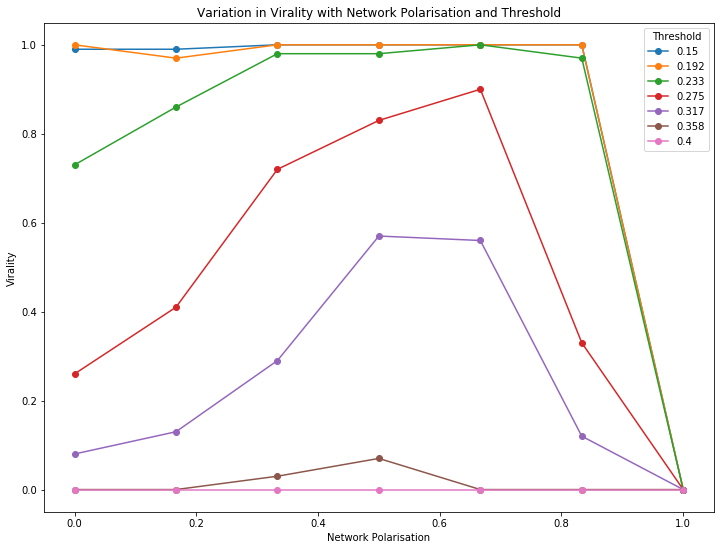

In [1140]:
opinion_polarisation = 0
N = 150
for threshold in threshold_list:
    virality = []
    for nwp in nw_polarisation_list:
        result = model_information_diffusion(nwp, N, opinion_polarisation, threshold, niter)
        spread = sum(i >= 0.5 for i in result)/niter
        virality.append(spread)
    plot(nw_polarisation_list, virality, label=round(threshold, 3), marker='o') 
plt.legend(title='Threshold')
plt.xlabel('Network Polarisation')
plt.ylabel('Virality')
plt.title('Variation in Virality with Network Polarisation and Threshold')
plt.show()

**Exercise 7:** Study the relationship between Virality and Threshold $(\theta)$ with varying measures of Opinion Polarisation


Discuss the results of the simulation and how does it relate to the overall phenomena

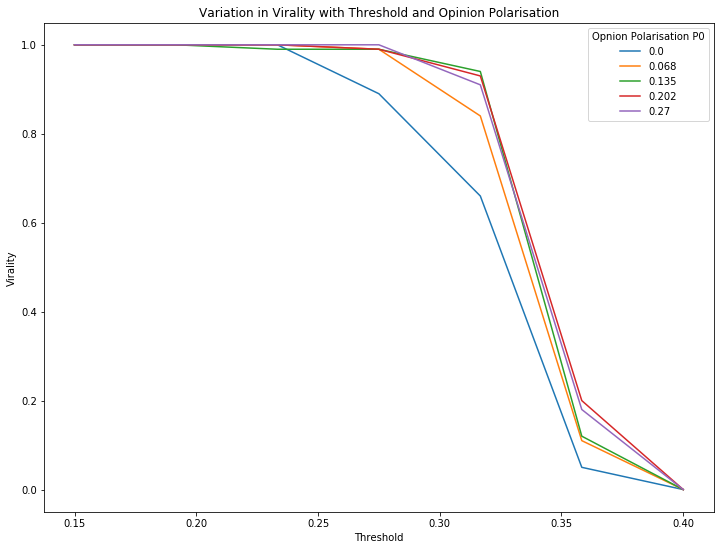

In [1141]:
N = 150
network_polarisation = 0.6
for op in opinion_polarisation_list:
    virality = []
    for threshold in threshold_list:
        result = model_information_diffusion(network_polarisation, N, op, threshold, niter)
        spread = sum(i >= 0.5 for i in result)/niter
        virality.append(spread)
    plot(threshold_list, virality, label= round(op,3)) 
plt.legend(title='Opnion Polarisation P0')
plt.xlabel('Threshold')
plt.ylabel('Virality')
plt.title('Variation in Virality with Threshold and Opinion Polarisation')
plt.show()

**Exercise 8:** Study the relationship between Virality and Network Polarisation with varying levels of Opinion Polarisation (P<sub>0</sub>). 

Discuss the results of the simulation and how does it relate to the overall phenomena

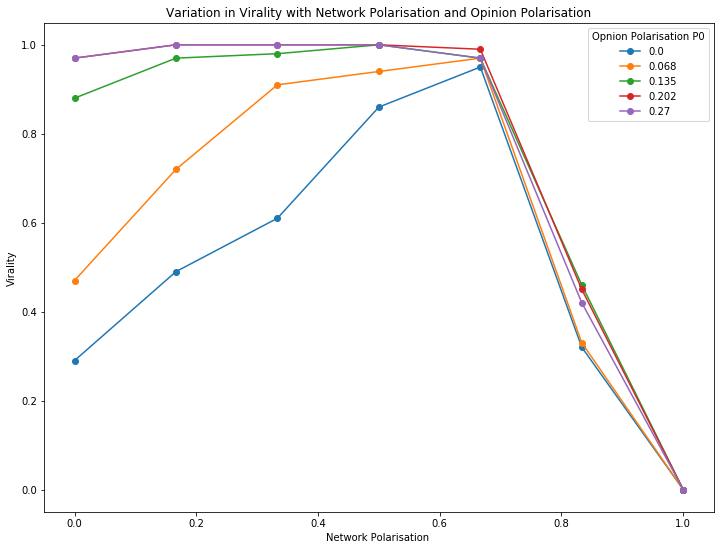

In [1142]:
threshold = 0.27
N =150
for op in opinion_polarisation_list:
    virality = []
    for nwp in nw_polarisation_list:
        result = model_information_diffusion(nwp, N, op, threshold, niter)
        spread = sum(i >= 0.5 for i in result)/niter
        virality.append(spread)
    plot(nw_polarisation_list, virality, label= round(op, 3), marker='o') 
plt.legend(title='Opnion Polarisation Po')
plt.xlabel('Network Polarisation ')
plt.ylabel('Virality')
plt.title('Variation in Virality with Network Polarisation and Opinion Polarisation')
plt.show()

In [ ]:
N_list = range(100, 250, 25) #[75, 100, 125, 150, 200, 225, 250, 300]
nw_polarisation_list = np.linspace(0,1,6) #range(0.01, 0.9, 0.075) #[0.075, 0.2, 0.4, 0.6, 0.8, 1]
threshold_list = np.linspace(0.10,0.5,7) #range(0.15, 0.4, 0.25) #[0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
opinion_polarisation_list = np.linspace(0.0,0.27,6) #range(0.0, 0.27, 0.03) #[0.0, 0.06, 0.12, 0.18, 0.24]
niter = 100
odel_information_diffusion(nw_polarisation, N, opinion_polarisation, threshold, niter):

In [911]:
x = model_information_diffusion(0.5, 150, 0.1, 0.2, 50)
sum(i >= 0.5 for i in x)

49

In [13]:
# Detecting echo chambers in the social network
partition = community.community_louvain.best_partition(er_graph)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(er_graph)

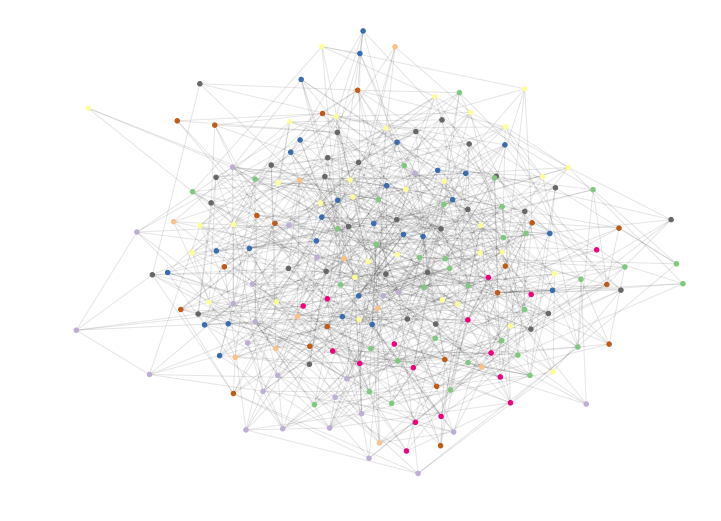

In [15]:
# Set figure width to 12 and height to 9
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

# Draw community graph
plt.axis('off')
nx.draw_networkx_nodes(er_graph, pos, node_size=20, cmap=plt.cm.Accent, node_color=list(partition.values()))
nx.draw_networkx_edges(er_graph, pos, alpha=0.1)


In [16]:
def read_graph(filename):
    G = nx.Graph()
    lines = [line.rstrip('\n') for line in open(filename, 'r')] 
    edge_list=list(map(lambda edge: [int(edge.split()[0]), int(edge.split()[1])], lines))
    G.add_edges_from(edge_list)
    return G

In [17]:
fb_graph=read_graph("../data/facebook_combined.txt")

In [18]:
print(nx.info(fb_graph))
print("Clustering Coefficient:", round(nx.average_clustering(fb_graph),4))


Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910
Clustering Coefficient: 0.6055


In [19]:
spring_pos = nx.spring_layout(fb_graph)

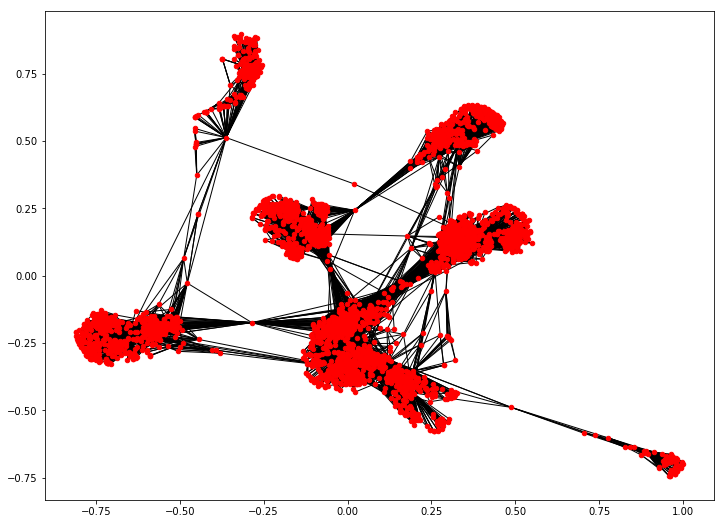

In [20]:

nx.draw_networkx(fb_graph, pos = spring_pos, with_labels=False, node_size=20)

In [21]:
#parts = community_louvain.best_partition(fb_graph)
#values = [parts.get(node) for node in fb_graph.nodes()]

NameError: name 'community_louvain' is not defined

In [22]:
# Detecting echo chambers in the social network
partition = community.community_louvain.best_partition(fb_graph)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(fb_graph)

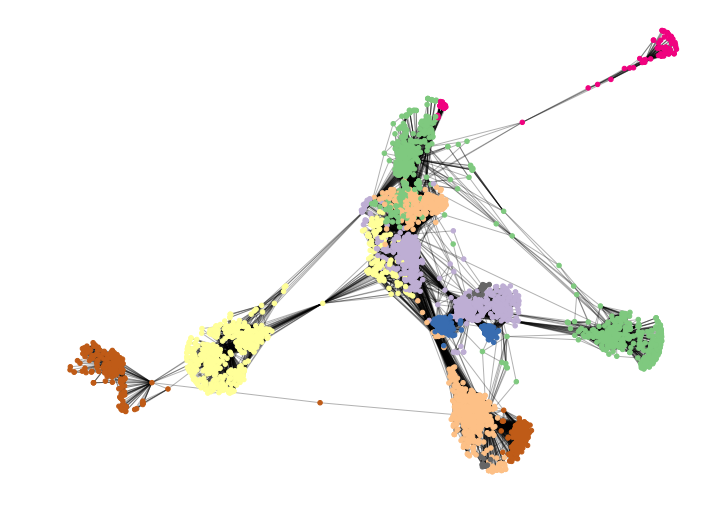

In [23]:
# Set figure width to 12 and height to 9
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

# Draw community graph
plt.axis('off')
nx.draw_networkx_nodes(fb_graph, pos, node_size=20, cmap=plt.cm.Accent, node_color=list(partition.values()))
nx.draw_networkx_edges(fb_graph, pos, alpha=0.3)


In [27]:
community.asyn_fluidc #community_louvain.modularity_max.greedy_modularity_communities(fb_graph)

AttributeError: module 'community' has no attribute 'asyn_fluidc'

In [48]:
set(partition.values())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}